## Setup and import some libraries

In [1]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip install torchrl
# pip install stable-baselines3[extra]
# !pip install torchvision
# !pip install gym==0.21
# !pip install --upgrade ipykernel
# !pip install matplotlib
# !pip install gym[atari,accept-rom-license]==0.21.0
# !pip install joblib
# !pip install tqdm

## Подключение библиотек

In [2]:
# hide imports
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torchvision
import numpy as np
import torchrl
import torch
import logging
import tqdm
from torchrl.envs import *
from torchrl.envs.libs.gym import *
from joblib import Parallel, delayed
import warnings
from multiprocessing import Pool
from agent import Agent
from constants import *
warnings.filterwarnings('ignore')

random_seed = 21

torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Версия gym

In [3]:
gym.version.VERSION

'0.21.0'

# Действие игры происходит в среде gym "Assault"

Давайте поменяем нашу среду для лучшего обучения.

Во-первых сделаем resize картинки до размера 64x64 (W = 64, H = 64).
Во-вторых переведем ее в черно-белое изображение.
В-третьих Добавим frameskip в 4 кадра.

Для этого воспользуемся классом TransformedEnv из torchrl.

In [4]:
#hide changing environment

_env = gym.make("CartPole-v1").env

n_actions = _env.action_space.n # see more info in actions.txt

print("n_actions =", n_actions)

from torchrl.envs import *
from torchrl.envs.libs.gym import *


env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=W, h=H),
        GrayScale(in_keys=["pixels_trsf"]),
        FrameSkipTransform(1), 
        ExcludeTransform("pixels")
    ),
).to(device)

n_actions = 2


Как мы видим state это TensorDict, состоящий из нескольких параметров, в том числе done, pixels_trsf (Измененное изображение), terminated, truncated.

In [5]:
state = env.reset()

print(state)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([1, 84, 84]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


## Посмотрим, как выглядит изменная среда

torch.Size([1, 84, 84])


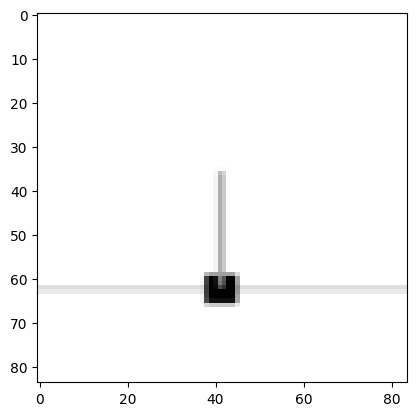

In [6]:
state = env.reset()

print(state['pixels_trsf'].shape)

plt.imshow(state['pixels_trsf'].cpu().permute(1, 2, 0), cmap="gray")

# Обучаем агента

### Для обучения агента я использую:
  * Нейронную сеть, состоящую из сверточных и полносвязных слоев. (Подробнее смотри файл network.py)
  * Реплей с приоритетами (TensorDictReplayBuffer) размера SIZE = 20000.
  * Optimizer - Adam
  * Для пересчета в Q-формуле использую target_network, которую обновляю каждые 30000 фреймов.
  
Для подробностей см. файл agent.py
Также есть возможность загрузки и сохранения агента.

In [7]:
# создаем агента
agent = Agent(num_channels=NUM_CHANNELS, width=W, height=H, n_actions=n_actions)

Добавим для наглядности графики

In [8]:
#hide plot
def plot(agent):
    clear_output(True)
    plt.figure(figsize=(20, 20))
    
    plt.subplot(221)
    plt.title('Rewards per frames')
    plt.xlabel("Frames")
    plt.ylabel("Reward")
    plt.plot(agent.frames, agent.reward_history, color='blue')
    
    plt.subplot(222)
    plt.title('Loss per frames')
    plt.xlabel("Frames")
    plt.ylabel("Loss")
    plt.plot(agent.frames, agent.loss_history, color='orange')
    
    plt.subplot(223)
    plt.title('Rewards per last 100 sessions')
    plt.xlabel("Sessions")
    plt.ylabel("Reward")
    plt.plot(agent.reward_history[-100:], color='blue')
    
    plt.subplot(224)
    plt.title('Loss per last 100 sessions')
    plt.xlabel("Sessions")
    plt.ylabel("Loss")
    plt.plot(agent.loss_history[-100:], color='orange')
    plt.show()

Играем сессию и записываем в агента опыт

In [9]:
# hide session

from tensordict import TensorDict

def play_session(agent, t_max=(int)(1e5), epsilon=0):
    # env = TransformedEnv(
    # GymEnv("CartPole-v1", from_pixels=True),
    # Compose(
    #     ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
    #     Resize(in_keys=["pixels_trsf"], w=W, h=H),
    #     GrayScale(in_keys=["pixels_trsf"]),
    #     FrameSkipTransform(1), 
    #     ExcludeTransform("pixels")
    # )).to(device)

    env = gym.make("CartPole-v1")

    total_reward = 0
    state = env.reset()
    
    frames = 0
    L = 0

    for t in range(t_max):
        action = agent.select_action(state, epsilon=epsilon)

        next_state, reward, done, info = env.step(action)

        _action = torch.tensor(action)
        # _action[action] = 1

        data = TensorDict({
            "state" : torch.as_tensor(state),
            "action" : np.asarray([np.asarray(_action)]),
            "reward": torch.as_tensor(reward),
            "next_state" : torch.as_tensor(next_state),
            "done" : torch.as_tensor(done)
            }, 
            batch_size=[]
        )

        agent.record_experience(data)

        # loss = agent.compute_loss(state['pixels_trsf'], np.asarray([np.asarray(_action)]), [next_state['reward']], next_state['pixels_trsf'], [next_state['done']])

        total_reward += reward

        state = next_state
        
        frames += 1

        if done:
            break
    
    return total_reward, frames

### Выбираем будем ли тренироваться и загружаться

In [10]:
loading = False
training = True
batch_size = 256

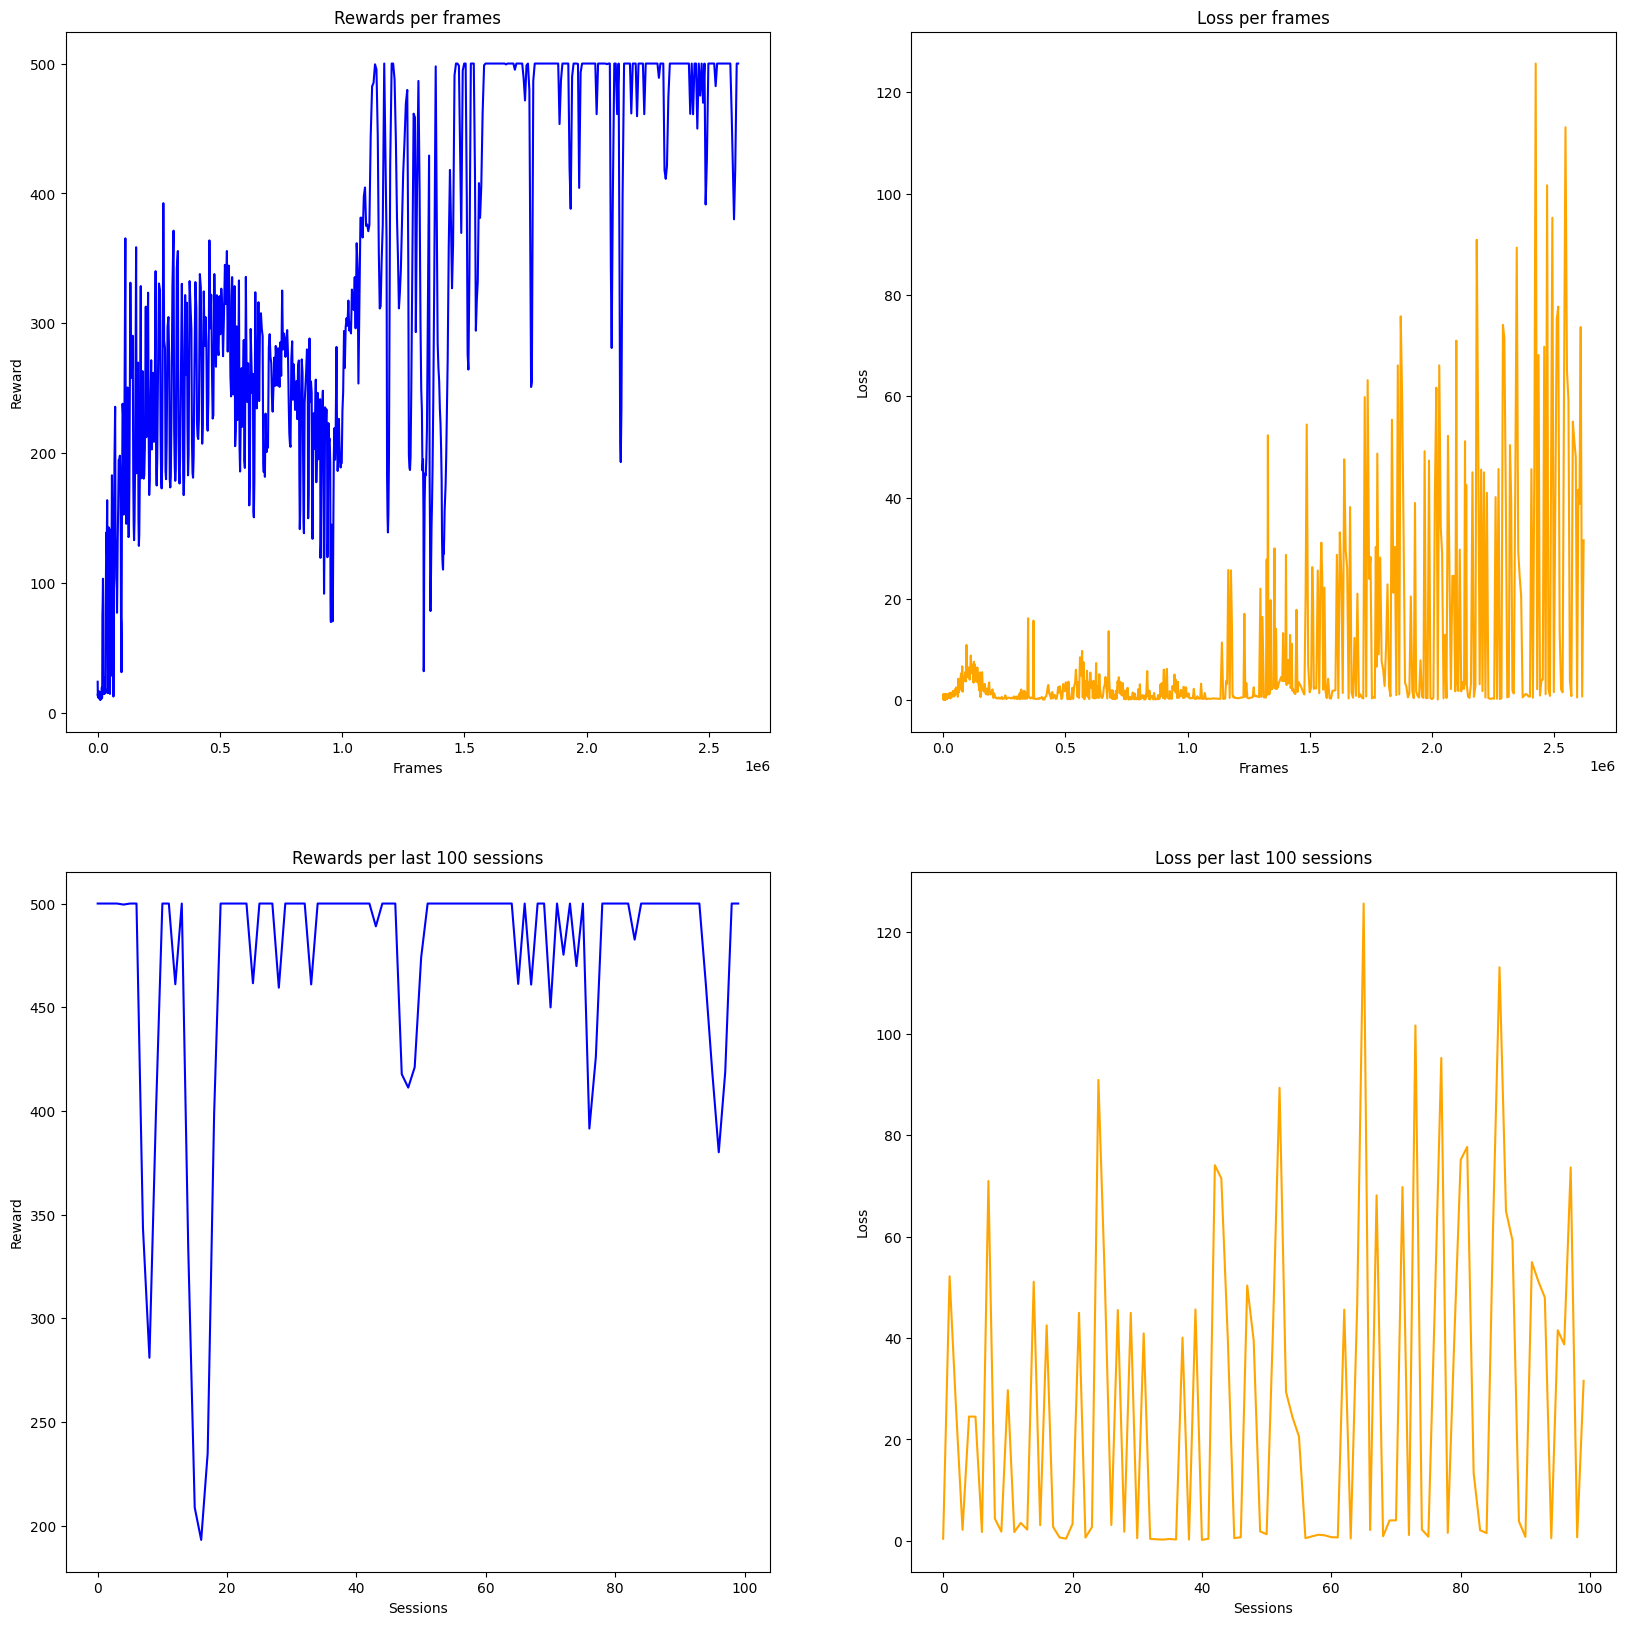

for frame =  2620035 , epsilon =  0.1063661846059355


  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[111.1630, 107.9229]])
tensor([[111.4468, 109.0490]])
tensor([[110.4167, 108.9472]])
tensor([[107.0981, 107.0771]])
tensor([[101.4513, 103.3298]])
tensor([[96.2768, 99.7037]])
tensor([[96.5882, 99.8829]])
tensor([[ 97.1430, 100.2467]])
tensor([[ 98.1010, 100.9572]])
tensor([[ 99.0235, 101.6035]])
tensor([[101.0233, 102.5515]])
tensor([[101.9603, 102.5230]])
tensor([[101.7862, 101.0968]])
tensor([[103.7482, 103.2434]])
tensor([[104.6533, 104.4796]])
tensor([[105.0789, 105.3816]])
tensor([[105.5176, 104.8748]])
tensor([[106.4255, 106.1397]])
tensor([[106.2831, 106.4732]])
tensor([[107.0311, 106.4383]])
tensor([[107.2389, 107.0986]])
tensor([[106.3552, 106.7652]])
tensor([[107.5022, 107.2696]])
tensor([[106.7360, 107.0296]])
tensor([[107.8051, 107.4617]])
tensor([[107.1768, 107.3293]])
tensor([[107.9623, 106.4712]])
tensor([[108.9732, 107.9917]])
tensor([[108.9589, 108.4677]])
tensor([[108.0853, 108.1439]])
tensor([[108.9839, 108.4949]])
tensor([[103.7448, 105.8930]])
tensor([[104

  8%|▊         | 1/12 [00:00<00:05,  2.13it/s]

tensor([[109.7117, 109.8323]])
tensor([[109.8704, 109.1746]])
tensor([[109.9380, 109.9333]])
tensor([[108.9593, 109.7146]])
tensor([[109.6213, 109.7887]])
tensor([[109.8188, 109.1818]])
tensor([[109.8264, 109.8830]])
tensor([[109.9308, 109.1576]])
tensor([[110.0629, 109.1203]])
tensor([[110.3193, 110.0512]])
tensor([[109.5332, 110.0154]])
tensor([[110.1386, 109.9955]])
tensor([[109.2459, 109.8611]])
tensor([[109.8598, 109.8727]])
tensor([[109.9289, 109.1171]])
tensor([[110.1005, 109.9814]])
tensor([[109.1887, 109.8300]])
tensor([[109.8021, 109.8456]])
tensor([[109.8970, 109.1231]])
tensor([[110.0298, 109.9500]])
tensor([[107.7138, 109.3411]])
tensor([[108.0647, 109.2213]])
tensor([[108.5854, 109.2460]])
tensor([[109.1057, 109.0852]])
tensor([[108.5627, 109.2411]])
tensor([[109.1173, 109.1136]])
tensor([[108.5893, 109.2686]])
tensor([[108.8848, 107.8709]])
tensor([[109.7120, 109.3181]])
tensor([[109.4561, 109.7424]])
tensor([[109.2186, 107.6097]])
tensor([[110.2219, 109.1903]])
tensor([

 17%|█▋        | 2/12 [00:00<00:04,  2.07it/s]

tensor([[110.0504, 109.3482]])
tensor([[110.0249, 110.0373]])
tensor([[110.1252, 109.3290]])
tensor([[110.1935, 110.1091]])
tensor([[109.1777, 109.8710]])
tensor([[109.8048, 109.9308]])
tensor([[110.0008, 109.3473]])
tensor([[109.9217, 109.9859]])
tensor([[110.0660, 109.3357]])
tensor([[110.0652, 110.0496]])
tensor([[109.0137, 109.7831]])
tensor([[109.6310, 109.8433]])
tensor([[109.9178, 109.3702]])
tensor([[109.7202, 109.8921]])
tensor([[109.9681, 109.3675]])
tensor([[109.8384, 109.9555]])
tensor([[110.0278, 109.3577]])
tensor([[109.9701, 110.0151]])
tensor([[110.0983, 109.3402]])
tensor([[110.1288, 110.0831]])
tensor([[109.0902, 109.8241]])
tensor([[109.7190, 109.8900]])
tensor([[109.8319, 109.9503]])
tensor([[110.0219, 109.3547]])
tensor([[107.3517, 109.2007]])
tensor([[107.7028, 109.0703]])
tensor([[108.1375, 109.0483]])
tensor([[108.6796, 108.9912]])
tensor([[108.7789, 108.2296]])
tensor([[109.0874, 109.2024]])
tensor([[109.0178, 108.2111]])
tensor([[109.6001, 109.4464]])
tensor([

 25%|██▌       | 3/12 [00:01<00:04,  1.82it/s]

tensor([[109.3015, 107.6954]])
tensor([[110.2391, 109.2376]])
tensor([[110.4573, 110.1358]])
tensor([[109.6075, 110.0439]])
tensor([[110.2385, 110.0660]])
tensor([[109.9018, 109.9180]])
tensor([[110.0638, 109.9905]])
tensor([[109.0265, 109.7324]])
tensor([[109.6579, 109.8003]])
tensor([[109.8871, 109.2606]])
tensor([[109.7799, 109.8668]])
tensor([[109.9515, 109.2535]])
tensor([[109.9206, 109.9328]])
tensor([[110.0279, 109.2377]])
tensor([[110.0906, 110.0075]])
tensor([[109.0587, 109.7519]])
tensor([[109.6961, 109.8227]])
tensor([[109.9085, 109.2607]])
tensor([[109.8267, 109.8912]])
tensor([[110.3466, 109.1659]])
tensor([[110.6822, 110.1706]])
tensor([[109.9891, 110.2399]])
tensor([[110.4959, 110.1079]])
tensor([[109.6950, 110.0798]])
tensor([[110.2592, 110.0393]])
tensor([[109.8988, 109.8850]])
tensor([[108.8402, 109.6258]])
tensor([[109.4328, 109.6742]])
tensor([[109.7510, 109.2586]])
tensor([[109.4728, 109.6997]])
tensor([[109.7896, 109.2722]])
tensor([[108.3991, 109.4014]])
tensor([

 33%|███▎      | 4/12 [00:02<00:04,  1.96it/s]

tensor([[109.8188, 109.8600]])
tensor([[109.9055, 109.1226]])
tensor([[110.0613, 109.9700]])
tensor([[109.1496, 109.8183]])
tensor([[109.7654, 109.8358]])
tensor([[109.8766, 109.1294]])
tensor([[109.9963, 109.9419]])
tensor([[109.0653, 109.7740]])
[500. 500. 500.] 500.0
tensor([[110.2872, 108.1296]])
tensor([[109.7646, 108.4178]])
tensor([[106.7948, 106.6639]])
tensor([[102.0518, 103.6982]])
tensor([[102.6416, 103.9613]])
tensor([[103.5410, 104.5077]])
tensor([[104.3451, 104.9286]])
tensor([[105.3733, 105.4944]])
tensor([[105.9867, 105.6208]])
tensor([[105.1874, 105.4644]])
tensor([[106.0037, 105.7856]])
tensor([[104.9444, 105.3703]])
tensor([[105.9029, 105.8186]])
tensor([[104.7123, 105.2747]])
tensor([[105.7587, 105.7905]])
tensor([[106.1750, 105.3960]])
tensor([[106.6355, 106.3764]])
tensor([[103.6414, 104.9453]])
tensor([[104.5717, 105.3395]])
tensor([[105.8228, 105.9825]])
tensor([[106.3328, 105.6773]])
tensor([[106.8125, 106.6278]])
tensor([[105.7299, 106.1661]])
tensor([[107.003

 42%|████▏     | 5/12 [00:02<00:03,  2.11it/s]

[500. 500. 500. 500.] 500.0
tensor([[110.0865, 108.5857]])
tensor([[108.3228, 107.7640]])
tensor([[104.9679, 105.7862]])
tensor([[105.4878, 105.9901]])
tensor([[106.1529, 106.2898]])
tensor([[107.1711, 106.8018]])
tensor([[104.8831, 105.5456]])
tensor([[105.9041, 106.0776]])
tensor([[106.6769, 106.3411]])
tensor([[105.4496, 105.8539]])
tensor([[106.3972, 106.2793]])
tensor([[104.9851, 105.6199]])
tensor([[106.0075, 106.1000]])
tensor([[106.4880, 105.8383]])
tensor([[106.5963, 106.5110]])
tensor([[105.1731, 105.8441]])
tensor([[106.3707, 106.4233]])
tensor([[106.8029, 106.1230]])
tensor([[107.1146, 106.9265]])
tensor([[105.7863, 106.3219]])
tensor([[107.0615, 106.9385]])
tensor([[105.7322, 106.3273]])
tensor([[107.0238, 106.9587]])
tensor([[105.6986, 106.3448]])
tensor([[107.2671, 106.4800]])
tensor([[107.6701, 107.4014]])
tensor([[106.8346, 107.1333]])
tensor([[107.9134, 106.7243]])
tensor([[108.5788, 107.9126]])
tensor([[108.1569, 108.0032]])
tensor([[106.5891, 107.2767]])
tensor([[10

 50%|█████     | 6/12 [00:03<00:03,  1.63it/s]

tensor([[109.7089, 109.5161]])
tensor([[109.2572, 109.7195]])
tensor([[109.8229, 109.5050]])
tensor([[109.4968, 109.8456]])
tensor([[109.9540, 109.4934]])
tensor([[109.7759, 109.9907]])
tensor([[110.0881, 109.4661]])
tensor([[110.0913, 110.1492]])
tensor([[110.3488, 110.2115]])
tensor([[110.1649, 110.1456]])
tensor([[109.2099, 109.9389]])
tensor([[109.8754, 110.0133]])
tensor([[110.0440, 109.3576]])
tensor([[110.0909, 110.1040]])
tensor([[110.1552, 109.3206]])
tensor([[110.3041, 110.1578]])
tensor([[109.4431, 110.0557]])
tensor([[110.0634, 110.0703]])
tensor([[110.1244, 109.2940]])
tensor([[110.2698, 110.1343]])
tensor([[109.3942, 110.0240]])
tensor([[109.9954, 110.0264]])
tensor([[110.0781, 109.2845]])
tensor([[110.1995, 110.1079]])
tensor([[109.2829, 109.9610]])
tensor([[109.8792, 109.9682]])
tensor([[110.0115, 109.2918]])
tensor([[110.0658, 110.0531]])
tensor([[109.1016, 109.8617]])
tensor([[109.7024, 109.8898]])
tensor([[109.9178, 109.3173]])
tensor([[109.8523, 109.9621]])
tensor([

 58%|█████▊    | 7/12 [00:03<00:03,  1.62it/s]

tensor([[109.7923, 109.4603]])
tensor([[108.3176, 109.4304]])
tensor([[108.8702, 109.4702]])
tensor([[109.4927, 109.3932]])
tensor([[107.8071, 109.1548]])
tensor([[108.3053, 109.1662]])
tensor([[108.9261, 109.1583]])
tensor([[109.4446, 109.4040]])
tensor([[108.8354, 109.4676]])
tensor([[109.4909, 109.4268]])
tensor([[109.5481, 109.4535]])
tensor([[108.9666, 109.5440]])
tensor([[109.6114, 109.4766]])
tensor([[109.0545, 109.5939]])
tensor([[109.6735, 109.4862]])
tensor([[109.1628, 109.6536]])
tensor([[109.7380, 109.4850]])
tensor([[109.2965, 109.7252]])
tensor([[109.8149, 109.4827]])
tensor([[108.4075, 109.5041]])
tensor([[108.9743, 109.5514]])
tensor([[109.5757, 109.4471]])
tensor([[109.0371, 109.5882]])
tensor([[109.6326, 109.4682]])
tensor([[109.1178, 109.6344]])
tensor([[109.7540, 109.4771]])
tensor([[109.3512, 109.7615]])
tensor([[109.8316, 109.4767]])
tensor([[109.9245, 109.4746]])
tensor([[109.6995, 109.9453]])
tensor([[110.0244, 109.4618]])
tensor([[109.9259, 110.0634]])
tensor([

 67%|██████▋   | 8/12 [00:04<00:02,  1.77it/s]

tensor([[109.8745, 109.9177]])
tensor([[109.9626, 109.1708]])
tensor([[110.1245, 110.0208]])
tensor([[109.2196, 109.8699]])
tensor([[109.8519, 109.8983]])
tensor([[109.2248, 107.3293]])
tensor([[110.3582, 109.0619]])
tensor([[110.5006, 108.9081]])
tensor([[111.1337, 110.1417]])
tensor([[110.9456, 110.6938]])
tensor([[109.9157, 110.5469]])
tensor([[110.3786, 110.4533]])
tensor([[110.6905, 110.0755]])
tensor([[108.8815, 109.9806]])
tensor([[109.2652, 109.8563]])
tensor([[109.7598, 109.7674]])
tensor([[109.8282, 109.0492]])
tensor([[109.9307, 109.8586]])
tensor([[109.0071, 109.7244]])
tensor([[109.5568, 109.7020]])
tensor([[109.7401, 109.1135]])
tensor([[109.7015, 109.7816]])
tensor([[109.8299, 109.1153]])
tensor([[109.8866, 109.8732]])
tensor([[108.9202, 109.6859]])
tensor([[109.7470, 109.1597]])
tensor([[109.6831, 109.7981]])
tensor([[109.8398, 109.1533]])
tensor([[109.8803, 109.8913]])
tensor([[109.9497, 109.1339]])
tensor([[110.1206, 109.9970]])
tensor([[109.2059, 109.8417]])
tensor([

 75%|███████▌  | 9/12 [00:05<00:01,  1.75it/s]

tensor([[109.8135, 110.1541]])
tensor([[110.2765, 109.9338]])
tensor([[109.6817, 110.0816]])
tensor([[110.1710, 109.9030]])
tensor([[109.5117, 109.9898]])
tensor([[110.0403, 109.8688]])
tensor([[109.2992, 109.8768]])
tensor([[109.8466, 109.7902]])
tensor([[109.0449, 109.7411]])
tensor([[109.6057, 109.6895]])
tensor([[109.6643, 108.9065]])
tensor([[109.8319, 108.8749]])
tensor([[110.2229, 109.9321]])
tensor([[109.5817, 110.0287]])
tensor([[110.1147, 109.8992]])
tensor([[109.4088, 109.9355]])
tensor([[109.9735, 109.8555]])
tensor([[109.1907, 109.8196]])
tensor([[109.7653, 109.7647]])
tensor([[109.5146, 109.6593]])
tensor([[109.6277, 108.9387]])
tensor([[109.8058, 109.7985]])
tensor([[108.9729, 109.7055]])
tensor([[109.5738, 109.6978]])
tensor([[109.6694, 108.9484]])
tensor([[109.8853, 109.8426]])
tensor([[109.0634, 109.7574]])
tensor([[109.6757, 109.7487]])
tensor([[109.7274, 108.9411]])
tensor([[110.0056, 109.8938]])
tensor([[108.9994, 109.7224]])
tensor([[109.6085, 109.7189]])
tensor([

 83%|████████▎ | 10/12 [00:05<00:01,  1.68it/s]

tensor([[108.1421, 109.2471]])
tensor([[108.7223, 109.3039]])
tensor([[109.2393, 109.0925]])
tensor([[108.8312, 109.3697]])
tensor([[109.3557, 109.1459]])
tensor([[108.9881, 109.4596]])
tensor([[109.2017, 109.5766]])
tensor([[109.6054, 109.1796]])
tensor([[109.0759, 107.3768]])
tensor([[110.1619, 109.0387]])
tensor([[110.5996, 110.0976]])
tensor([[110.1039, 110.3153]])
tensor([[110.5705, 110.0676]])
tensor([[110.0619, 110.2862]])
tensor([[110.5217, 110.0427]])
tensor([[109.9796, 110.2369]])
tensor([[110.4404, 110.0085]])
tensor([[109.8546, 110.1662]])
tensor([[110.3324, 109.9716]])
tensor([[109.6839, 110.0727]])
tensor([[110.1949, 109.9314]])
tensor([[109.4630, 109.9539]])
tensor([[110.0135, 109.8741]])
tensor([[109.1865, 109.8073]])
tensor([[109.7517, 109.7611]])
tensor([[109.7893, 108.9677]])
tensor([[110.0279, 109.8916]])
tensor([[109.7764, 109.7809]])
tensor([[109.8106, 108.9782]])
tensor([[110.0610, 109.9110]])
tensor([[109.2342, 109.8357]])
tensor([[109.8240, 109.8067]])
tensor([

 92%|█████████▏| 11/12 [00:06<00:00,  1.72it/s]

tensor([[110.0520, 109.2738]])
tensor([[110.0961, 110.0300]])
tensor([[109.0638, 109.7799]])
tensor([[109.6898, 109.8447]])
tensor([[109.9180, 109.3055]])
tensor([[109.7952, 109.9000]])
tensor([[109.9774, 109.3002]])
tensor([[109.9224, 109.9594]])
tensor([[110.0477, 109.2866]])
tensor([[110.0782, 110.0282]])
tensor([[109.0356, 109.7667]])
tensor([[109.6623, 109.8318]])
tensor([[109.7726, 109.8919]])
tensor([[109.9717, 109.3097]])
tensor([[109.9042, 109.9559]])
tensor([[110.0414, 109.2956]])
tensor([[110.0591, 110.0240]])
tensor([[109.0084, 109.7539]])
tensor([[109.6344, 109.8187]])
tensor([[109.7431, 109.8779]])
tensor([[109.9627, 109.3181]])
tensor([[109.8799, 109.9489]])
tensor([[110.0311, 109.3042]])
tensor([[110.0320, 110.0157]])
tensor([[109.5958, 109.8001]])
tensor([[109.8913, 109.3337]])
tensor([[109.6998, 109.8570]])
tensor([[109.9469, 109.3282]])
tensor([[109.8350, 109.9295]])
tensor([[110.0129, 109.3152]])
tensor([[109.9872, 110.0003]])
tensor([[110.0909, 109.2942]])
tensor([

100%|██████████| 12/12 [00:06<00:00,  1.77it/s]

tensor([[108.2868, 109.3254]])
tensor([[108.9010, 109.3883]])
tensor([[109.2473, 108.9552]])
tensor([[109.1299, 109.5111]])
tensor([[109.3984, 108.9556]])
tensor([[109.4240, 109.6539]])
tensor([[109.5651, 108.9226]])
tensor([[109.7980, 109.8217]])
tensor([[109.7591, 108.8665]])
tensor([[110.1768, 109.9294]])
tensor([[108.4606, 109.7276]])
tensor([[109.4892, 109.6589]])
tensor([[109.5757, 108.8726]])
tensor([[109.8610, 109.8287]])
tensor([[109.1115, 109.7872]])
tensor([[109.7230, 109.7638]])
tensor([[109.6982, 108.8372]])
tensor([[110.0954, 109.8933]])
tensor([[109.4593, 109.9761]])
tensor([[110.0325, 109.8698]])
tensor([[109.3646, 109.9231]])
tensor([[109.9510, 109.8443]])
tensor([[109.2426, 109.8550]])
tensor([[109.8290, 109.7933]])
tensor([[109.0880, 109.7699]])
tensor([[109.6705, 109.7237]])
tensor([[109.6556, 108.8188]])
tensor([[110.0387, 109.8682]])
tensor([[109.3753, 109.9280]])
tensor([[109.9563, 109.8429]])
tensor([[109.2517, 109.8591]])
tensor([[109.8341, 109.7927]])
tensor([

In [11]:
if training:
    if loading:
        agent.load()

    agent.save()

    print("preparing (add random states to replay buffer)")
    if not loading:
        for i in tqdm.tqdm(range(2000)):
            play_session(agent, epsilon=1)
    else:
        for i in tqdm.tqdm(range(20)):
            play_session(agent, epsilon=agent.epsilon)
    
    epoch = 0
    while True:
        rewards = np.asarray([])
        count_frames = 0
        for _ in tqdm.tqdm(range(12)):
                rewards_for_session, cnt = play_session(agent, t_max=(int)(agent.t_max), epsilon=agent.epsilon)
                rewards_for_session = np.asarray(torch.as_tensor(rewards_for_session).cpu())
                print(rewards, rewards_for_session)
                rewards = np.concatenate([rewards, [rewards_for_session]])
                count_frames += cnt
        
        agent.epsilon *= 0.99

        # loss = agent.train(batch_size)
        
        Loss = agent.train(400)
        agent.loss_history.append(Loss)
        agent.reward_history.append(np.mean(rewards))
        last_frames = 0
        if len(agent.frames) != 0:
            last_frames = agent.frames[-1]
        agent.frames.append(last_frames + count_frames)
        clear_output(True)
        
        plot(agent)
        print("for frame = ", last_frames + count_frames, ", epsilon = ", agent.epsilon)

        if agent.epsilon < 0.1:
            agent.epsilon = 0.12
        
        agent.t_max *= 1.01
        epoch += 1
        agent.t_max = min(agent.t_max, (int)(4e4))

        if epoch % 10 == 1:
            agent.save()
            print('saved successfully')     

In [ ]:
if not training:
    pass # lets see result!